In [9]:
import os
from pathlib import Path
import pydicom
from pandas import DataFrame
import traceback

import matplotlib.pyplot as plt
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.utils   import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *
from LazyLuna.loading_functions import *

In [ ]:
# annotations from cvi42 workspace
# automatically finds both image folders
# get sops from it
# load images (seriesdescription) from first case with annotations
# load images from second case with the same image positions
# sort into category so that the same annotation is provided for both

In [2]:
bp        = '/Users/dietrichhadler/Desktop/Daten/FatFraction'
bp_annos  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Gold'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Imgs'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Cases'

In [ ]:
parse_cvi42ws(bp_annos, bp_annos, process=True, debug=False)

In [3]:
n = 1
paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)
imgp, annop = paths[n]
print(imgp)
print(annop)

/Users/dietrichhadler/Desktop/Daten/FatFraction/Imgs/MyoMet-CMR-010_050Y
/Users/dietrichhadler/Desktop/Daten/FatFraction/Gold/1.3.6.1.4.1.53684.1.1.2.0.564.1631697203.665785


1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161249.1


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


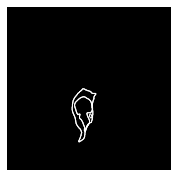

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161248.1


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


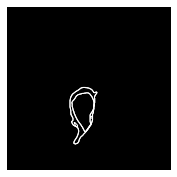

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161243.1


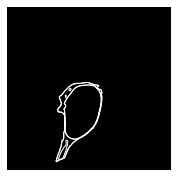

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161242.1


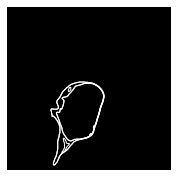

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161239.1


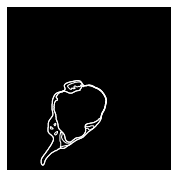

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161244.1


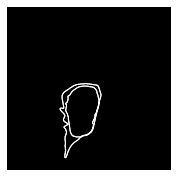

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161245.1


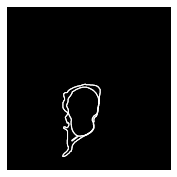

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161252.1


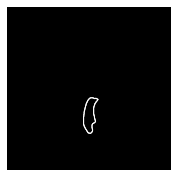

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161240.1


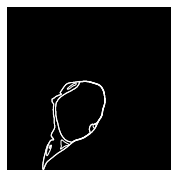

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161241.1


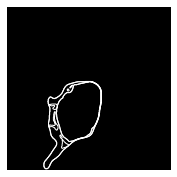

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161250.1


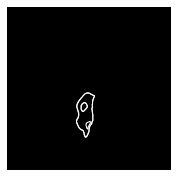

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161251.1


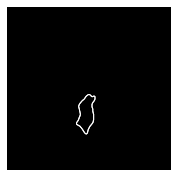

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161247.1


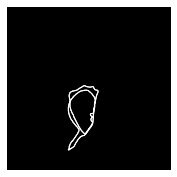

1.3.6.1.4.1.53684.1.1.4.0.561.3.6.1.4.1.53684.1.1.4.0.56220530165312401970.161246.1


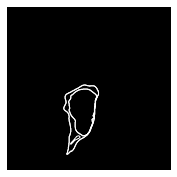

In [4]:
annos = [Annotation(os.path.join(annop,a), a.replace('.pickle','')) for a in os.listdir(annop) if 'case' not in a]
annos = {a.sop:a for a in annos}
sops  = [a.sop for a in annos.values()]

for sop in annos.keys():
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    print(sop)
    ax.imshow(np.zeros((150,150)), cmap='gray')
    ax.axis('off')
    annos[sop].plot_all_contour_outlines(ax)
    plt.show()

In [12]:
annos   = [Annotation(os.path.join(annop,a), a.replace('.pickle','')) for a in os.listdir(annop) if 'case' not in a]
annos   = {a.sop:a for a in annos}
sops    = [a.sop for a in annos.values()]
dcms    = []
dcms_ff = []
for ip, p in enumerate(Path(imgp).glob('**/*.dcm')):
    try:
        p = str(p)
        dcm = pydicom.dcmread(p, stop_before_pixels=True)
        if dcm.SOPInstanceUID in sops:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms.append(dcm)
        if '_W_FF' in dcm.SeriesDescription and 'rs3dt2d' in dcm.SeriesDescription:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms_ff.append(dcm)
    except:
        pass
dcms     = {dcm.SOPInstanceUID:dcm for dcm in dcms}
dcms_ff  = sorted(dcms_ff, key=lambda x: float(x.SliceLocation))
dcms_tmp = dict()
for sop in dcms.keys():
    dcm = dcms[sop]
    slloc = dcm.SliceLocation
    for dcm2 in dcms_ff:
        if dcm2.SliceLocation==slloc:
            dcms_tmp[sop] = dcm2
dcms_ff = dcms_tmp
print(len(annos))
print(len(dcms))
print(len(dcms_ff))

14
14
14


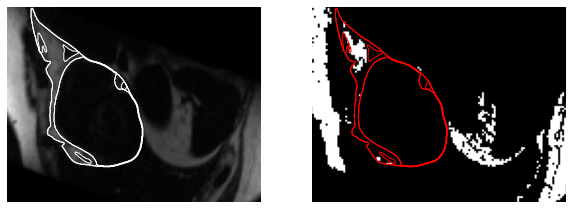

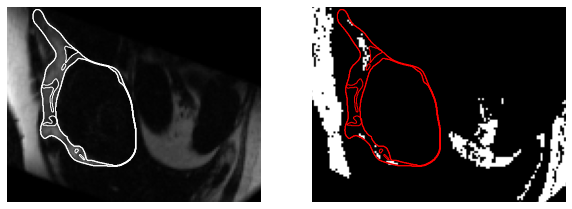

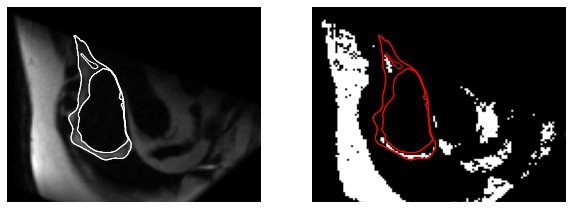

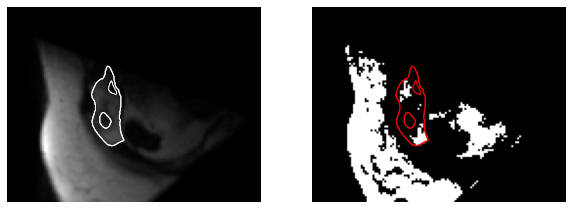

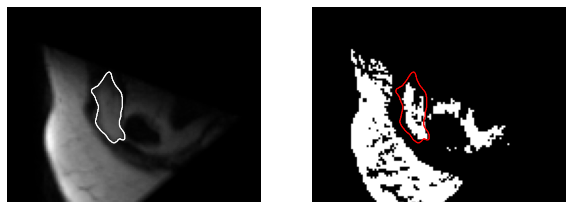

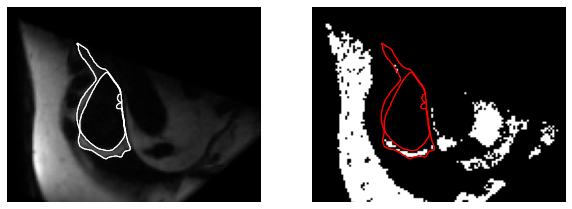

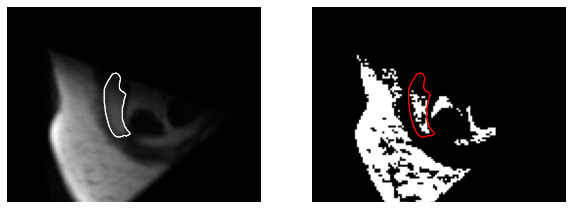

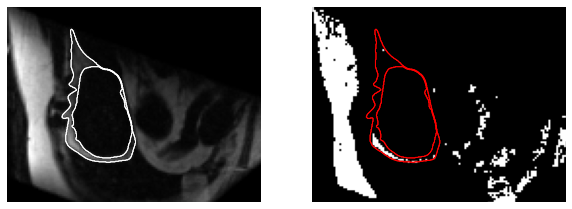

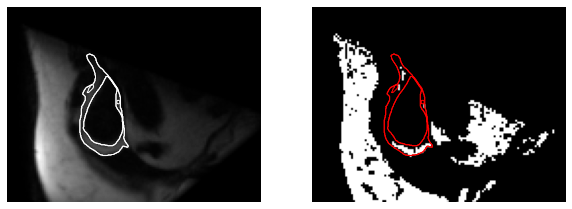

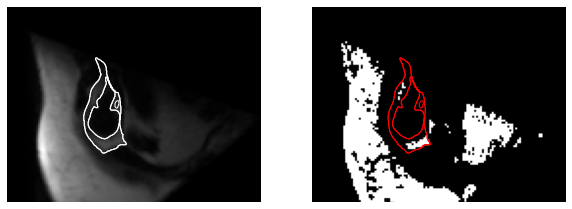

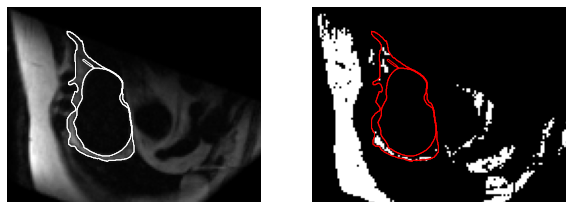

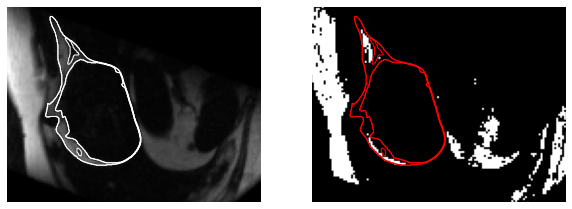

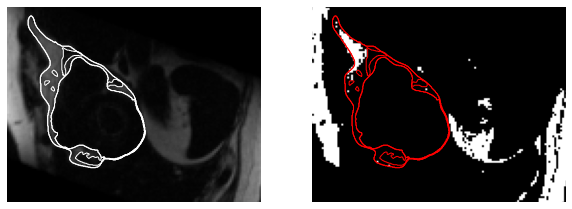

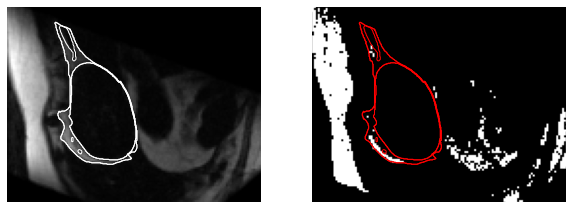

In [13]:
for sop in dcms.keys():
    try:
        img1 = dcms[sop].pixel_array
        img2 = dcms_ff[sop].pixel_array
        h, w = img1.shape
        anno = annos[sop]
        fig, axes = plt.subplots(1,2, figsize=(10,15))
        extent=(0, w, h, 0)
        axes[0].imshow(img1, cmap='gray', extent=extent); axes[0].axis('off')
        axes[1].imshow(img2, cmap='gray', extent=extent); axes[1].axis('off')
        anno.plot_all_contour_outlines(axes[0])
        anno.plot_all_contour_outlines(axes[1], 'r')
        for ax in axes: ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
        plt.show()
    except Exception as e:
        print(traceback.format_exc())

In [19]:
class FF_Category:
    def __init__(self, dcms_fat, dcms_ff, annos):
        self.dcms_fat  = dcms_fat 
        self.dcms_ff   = dcms_ff
        self.annos     = annos
        self.depth2sop = self.sort_sops_2_depth(dcms_fat)
        self.nr_slices = len(self.depth2sop.values())
        self.set_params()
        
    def set_params(self):
        dcm1, dcm2 = self.get_fat_dcm(0), self.get_fat_dcm(1)
        self.slice_thickness = dcm1.SliceThickness
        self.spacing_between_slices = np.abs(dcm1.SliceLocation - dcm2.SliceLocation)
        self.ph, self.pw = dcm1.PixelSpacing
        
    def sort_sops_2_depth(self, dcms):
        sl_locs = [(dcm.SOPInstanceUID, float(dcm.SliceLocation)) for dcm in dcms.values()]
        sl_locs = sorted(sl_locs, key=lambda x:x[1])
        depth2sop = {i:x[0] for i,x in enumerate(sl_locs)}
        return depth2sop
        
    def get_fat_dcm(self, depth): return self.dcms_fat[self.depth2sop[depth]]
    def get_ff_dcm (self, depth): return self.dcms_ff[self.depth2sop[depth]]
    def get_fat_img(self, depth): return self.get_fat_dcm(depth).pixel_array
    def get_ff_img (self, depth): return self.get_ff_dcm(depth).pixel_array
    def get_anno   (self, depth): return self.annos[self.depth2sop[depth]]
    
    def get_ff_in_myo(self, depth):
        ff_cont = utils.to_polygon(self.get_ff_img(depth))
        anno = self.get_anno(depth)
        pixels_inside_myo = anno.get_contour('lv_myo').intersection(ff_cont)
        pixels_inside_myo = utils.geometry_collection_to_Polygon(pixels_inside_myo)
        return pixels_inside_myo
    
    # in ml
    def get_ff_volume(self):
        try:
            dcm_tmp = self.get_ff_dcm(0)
            ph, pw = self.ph, self.pw
            annos = [self.get_ff_in_myo(d) for d in range(self.nr_slices)]
            areas = [self.get_ff_in_myo(d).area for d in range(self.nr_slices)]
            has_conts = [a!=0 for a in areas]
            top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
            total_vol = 0
            for d in range(self.nr_slices):
                area = self.get_ff_in_myo(d).area - anno.get_contour('rv_pamu').area
                pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
                total_vol += ph * pw * pd * area
            return total_vol / 1000
        except Exception as e:
            print(traceback.format_exc())
    
    # in ml
    def get_fat_volume(self):
        try:
            dcm_tmp = self.get_fat_dcm(0)
            ph, pw = self.ph, self.pw
            annos = [self.get_anno(d) for d in range(self.nr_slices)]
            areas = [a.get_contour('lv_myo').area if a is not None else 0.0 for a in annos]
            has_conts = [a!=0 for a in areas]
            top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
            total_vol = 0
            for d in range(self.nr_slices):
                anno = self.get_anno(d)
                area = anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area
                pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
                total_vol += ph * pw * pd * area
            return total_vol / 1000
        except Exception as e:
            print(traceback.format_exc())
    
    def get_area_table(self):
        try:
            rows = []
            ph, pw = self.ph, self.pw
            pd = self.spacing_between_slices
            for d in range(self.nr_slices):
                anno = self.get_anno(d)
                area1 = ph*pw*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area)
                area2 = ph*pw*self.get_ff_in_myo(d).area
                rows.append([area1, pd*area1/1000, area2, pd*area2/1000])
            cols = ['Fat Areas [mm^2]', 'Fat Volume [ml]', 'FF Areas [mm^2]', 'FF Volume [ml]']
            return DataFrame(rows, columns=cols)
        except Exception as e:
            print(traceback.format_exc())
    
    def get_cr_table(self):
        try:
            rows = [[cat.get_fat_volume(), cat.get_ff_volume()]]
            cols = ['Fat Volume [ml]', 'FF Volume [ml]']
            return DataFrame(rows, columns=cols)
        except Exception as e:
            print(traceback.format_exc())
    
    def store_tables(self, folder_path, case_name):
        try:
            df = self.get_cr_table()
            path = os.path.join(folder_path, case_name+'_clinical_result.csv')
            pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')
        except Exception as e:
            print(traceback.format_exc())
        try:
            df = self.get_area_table()
            path = os.path.join(folder_path, case_name+'_areas.csv')
            pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')
        except Exception as e:
            print(traceback.format_exc())

cat = FF_Category(dcms, dcms_ff, annos)

display(cat.get_area_table())
display(cat.get_cr_table())
cat.store_tables(folder_path=bp_cases)

,Fat Areas [mm^2],Fat Volume [ml],FF Areas [mm^2],FF Volume [ml]
0,2303.622344,16.125352,422.067583,2.954472
1,2180.478496,15.263345,407.990503,2.855933
2,2429.948836,17.009637,222.662684,1.558638
3,1694.023573,11.858162,284.234608,1.989642
4,1422.029904,9.954207,183.736497,1.286155
5,1638.327300,11.468288,184.226135,1.289583
6,1621.802032,11.352611,235.882898,1.651180
7,1561.209383,10.928463,213.481979,1.494373
8,1143.670947,8.005694,177.616027,1.243312
9,1175.007752,8.225052,238.331086,1.668317


,Fat Volume [ml],FF Volume [ml]
0,156.797822,28.459932


TypeError: store_tables() missing 1 required positional argument: 'case_name'

In [20]:
path = os.path.join(bp_cases, 'test_cat.pickle')
pickle.dump(cat, open(path, 'wb'), pickle.HIGHEST_PROTOCOL)

In [21]:
new_cat = pickle.load(open(path, 'rb'))
cat = new_cat

/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


0
588.09375
107.75


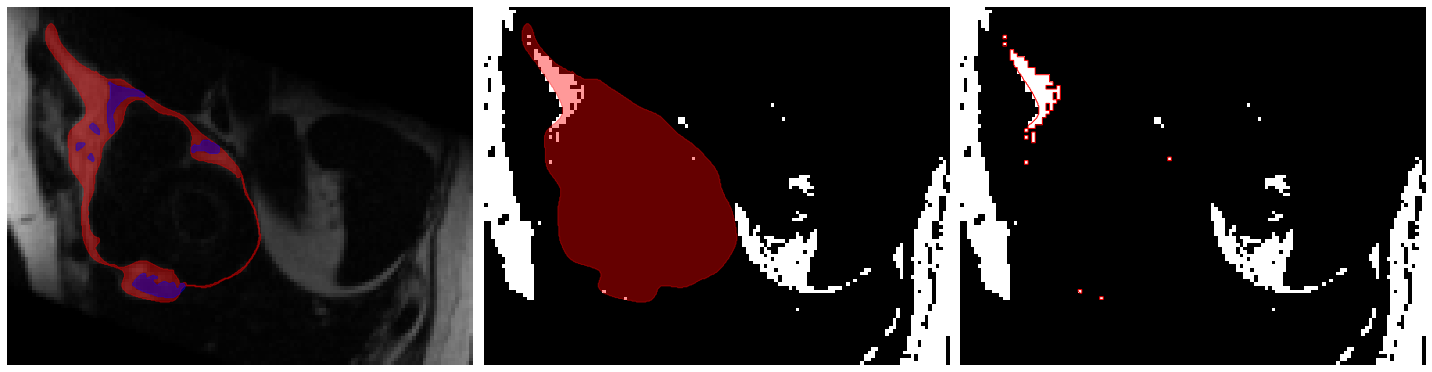

1
556.65625
104.15625


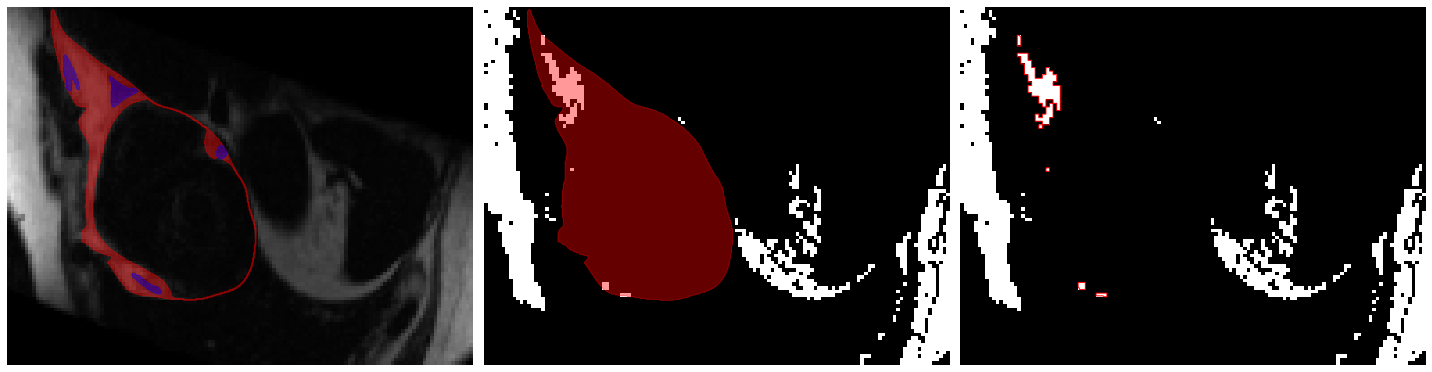

2
620.34375
56.84375


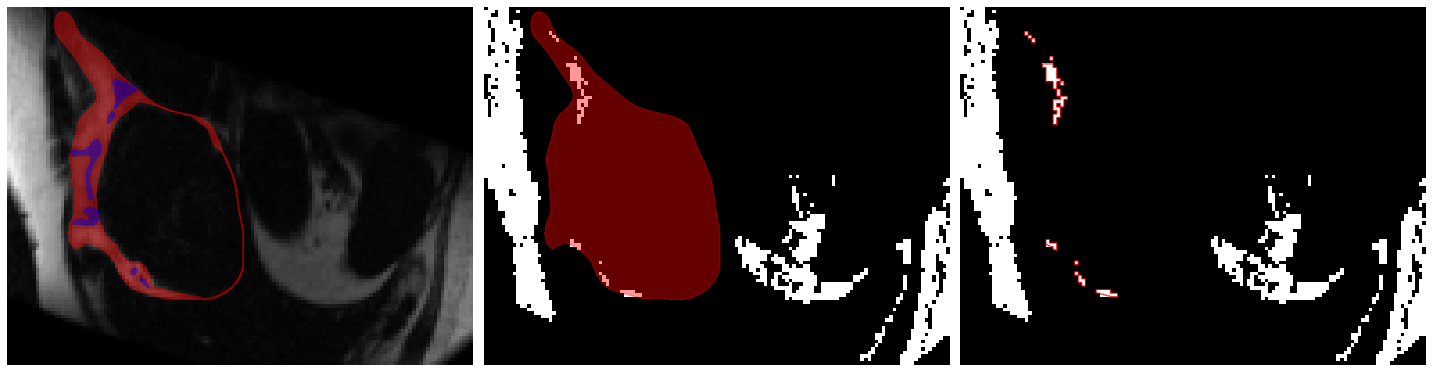

3
432.46875
72.5625


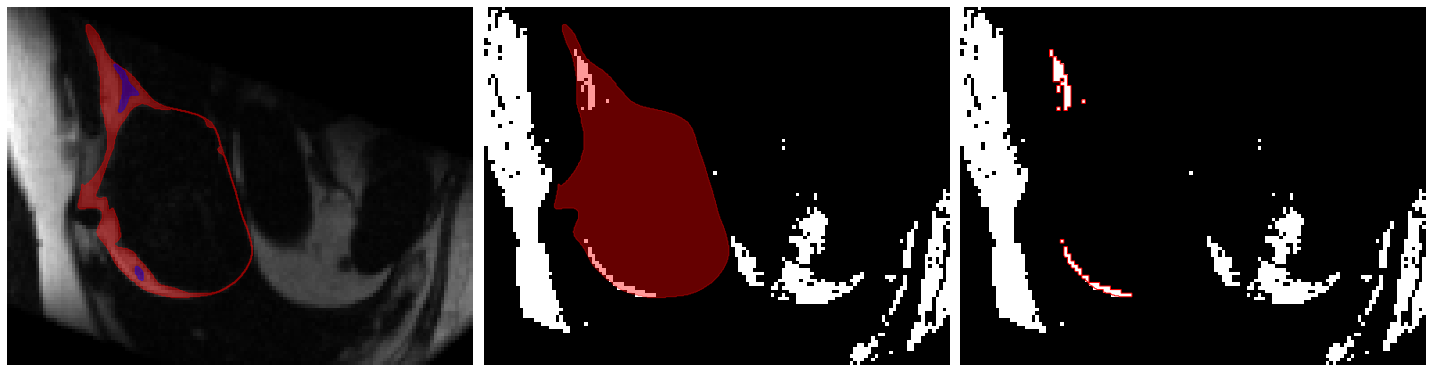

4
363.03125
46.90625


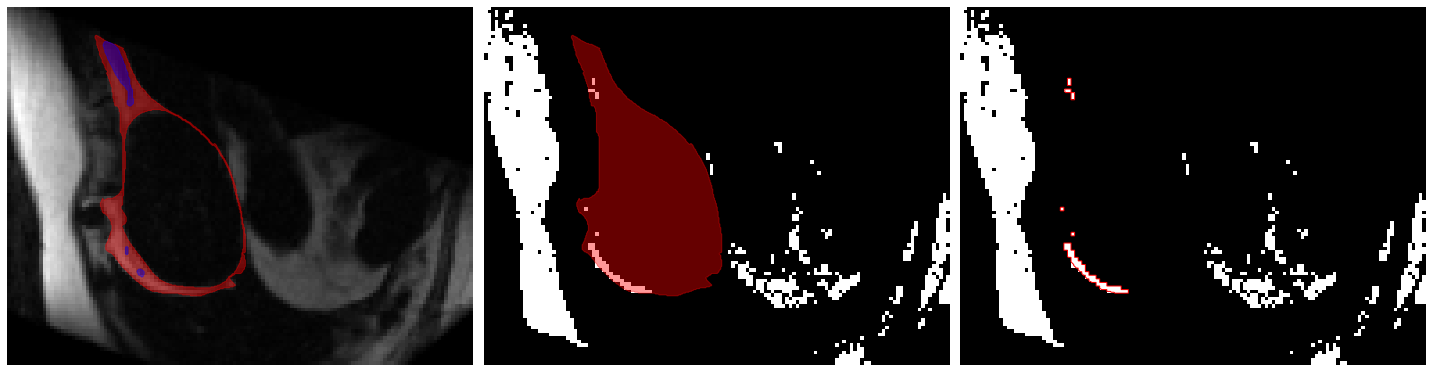

5
418.25
47.03125


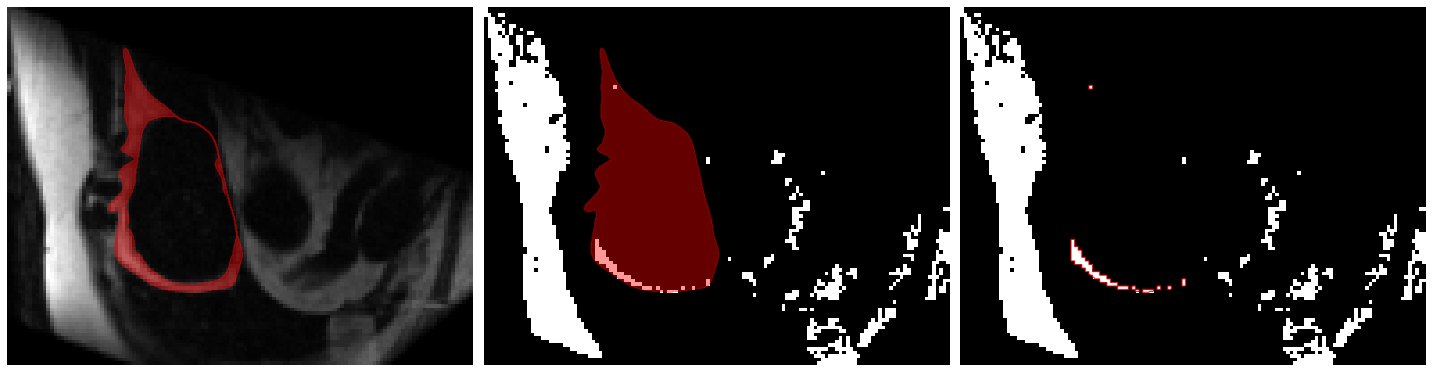

6
414.03125
60.21875


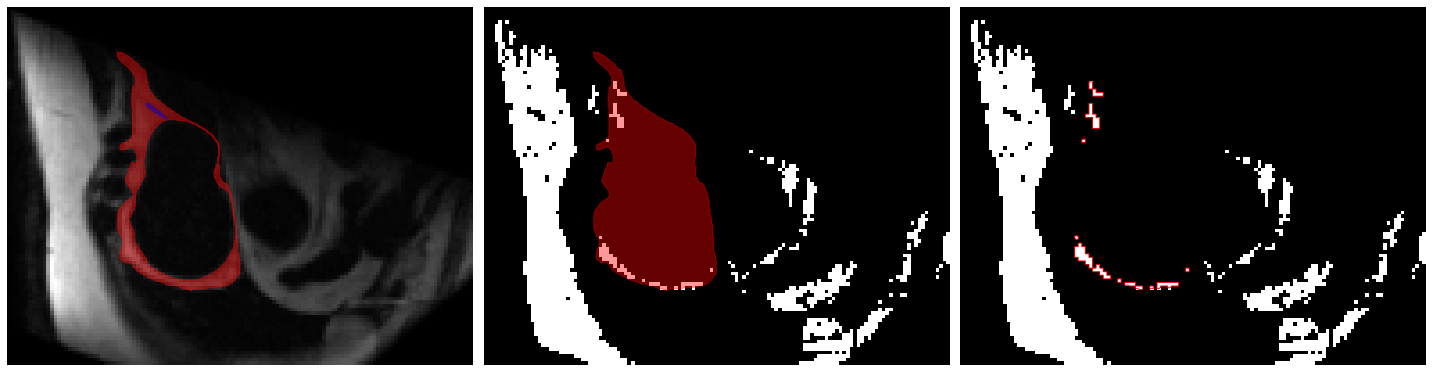

7
398.5625
54.5


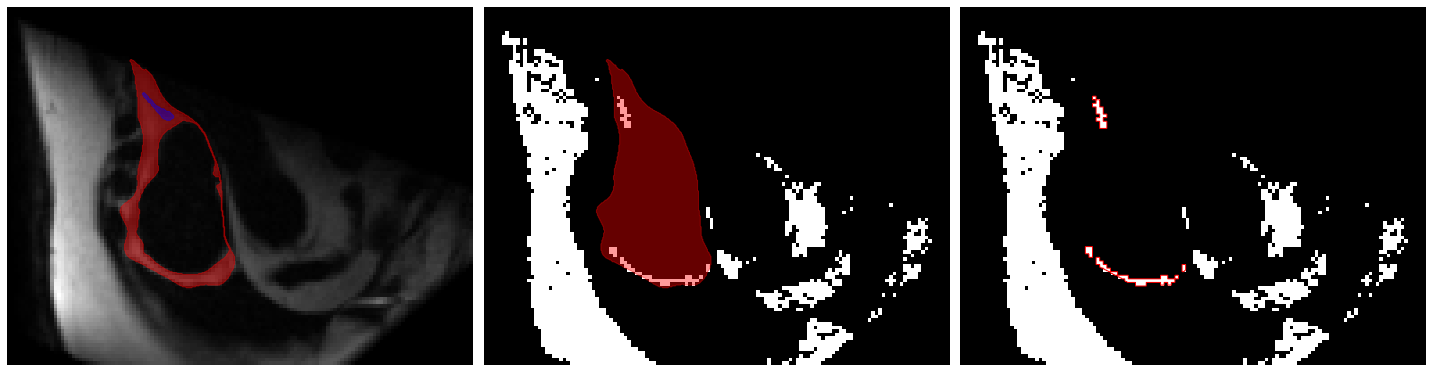

8
291.96875
45.34375


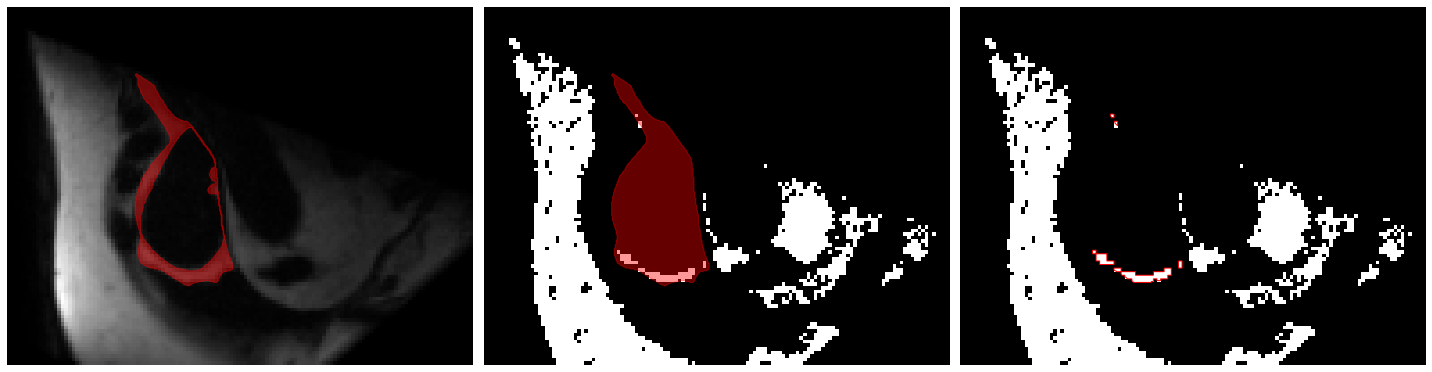

9
299.96875
60.84375


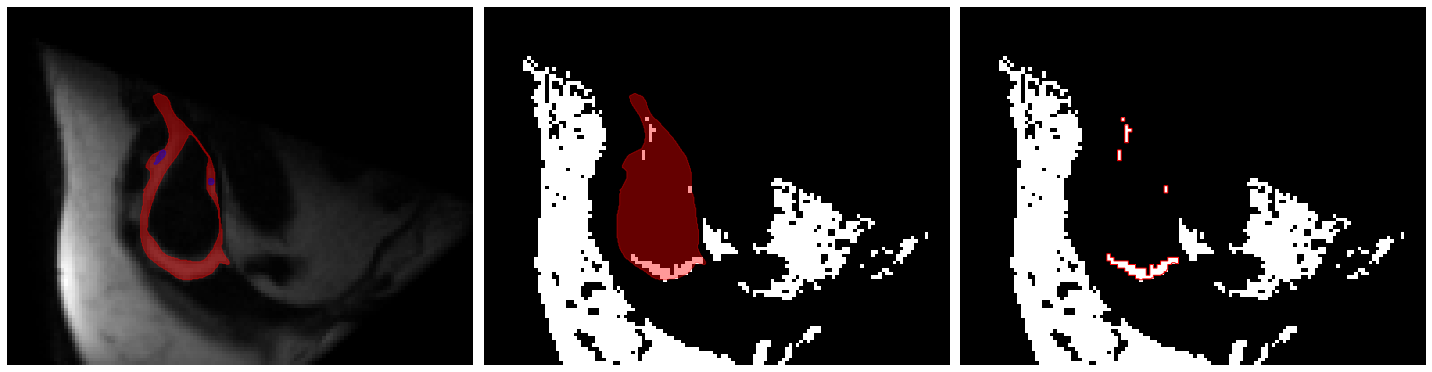

10
308.3125
47.0625


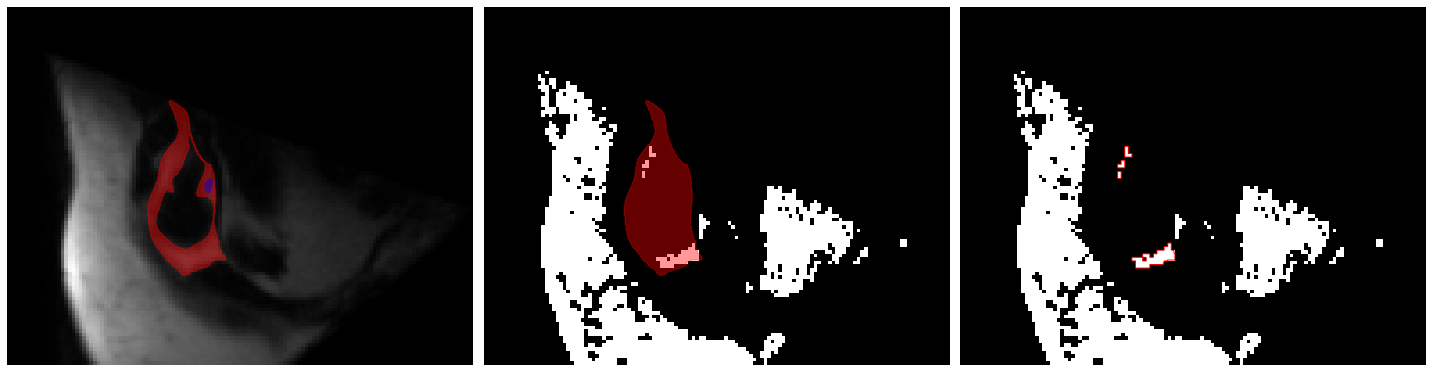

11
391.34375
75.1875


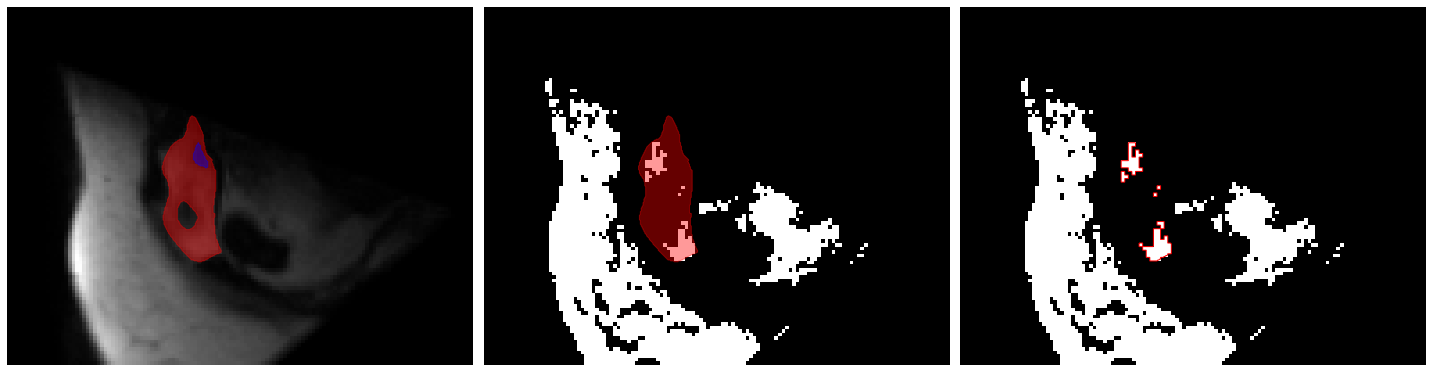

12
374.0625
180.53125


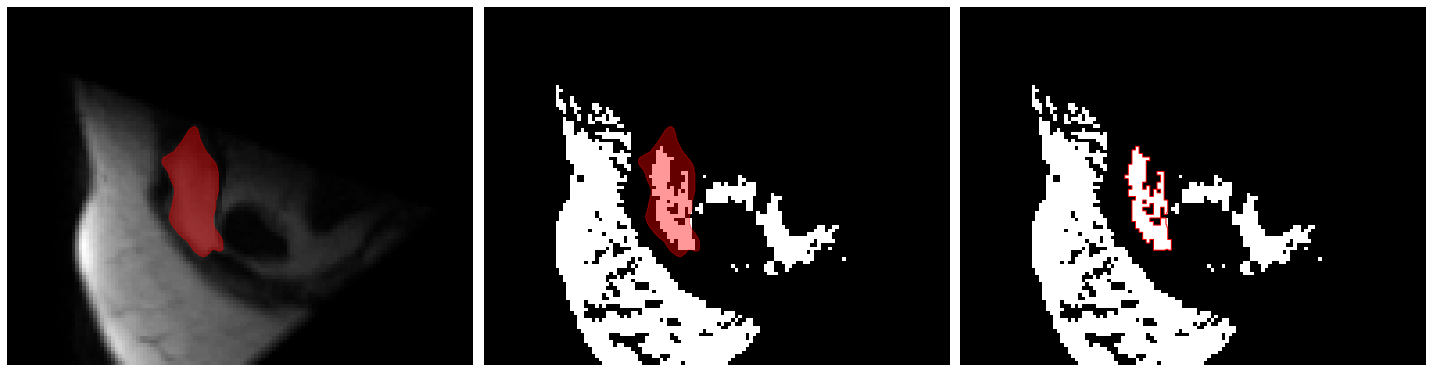

13
261.34375
79.0


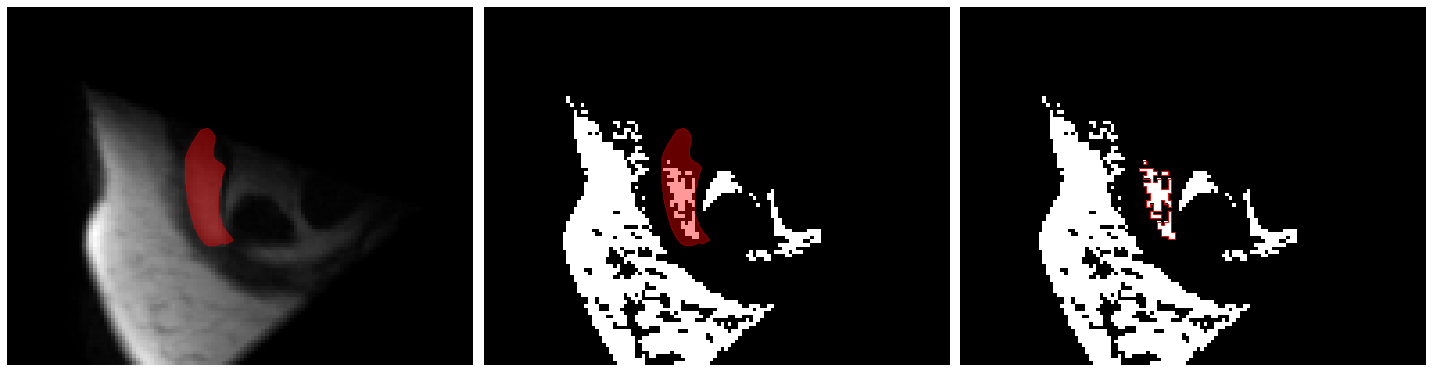

In [22]:
for d in range(cat.nr_slices):
    fig, axes = plt.subplots(1,3, figsize=(20,9))
    img    = cat.get_fat_img(d)
    h, w   = img.shape
    ph, pw = cat.ph, cat.pw
    extent = (0, w, h, 0)
    axes[0].imshow(cat.get_fat_img(d), cmap='gray', extent=extent); axes[0].axis('off')
    axes[1].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[1].axis('off')
    axes[2].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[2].axis('off')
    anno = cat.get_anno(d)
    anno.plot_contour_face(axes[0], 'lv_myo')
    anno.plot_contour_face(axes[0], 'rv_pamu', 'b')
    #anno.plot_contour_face(axes[1], 'lv_myo')
    anno.plot_contour_face(axes[1], 'lv_epi')
    #anno.plot_contour_face(axes[1], 'rv_pamu', 'b')
    ff_pixel_polygon = cat.get_ff_in_myo(d)
    utils.plot_outlines(axes[2], ff_pixel_polygon, 'r')
    for ax in axes:
        ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
    print(d)
    #pixel_area = ph*pw
    pixel_area = 1
    print(pixel_area*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area))
    print(pixel_area*(ff_pixel_polygon.area))
    fig.tight_layout()
    plt.show()